<a href="https://colab.research.google.com/github/AlexxLai/ml0716/blob/master/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
f = zipfile.ZipFile("drive/My Drive/additional/train.zip")
f.extractall("datas")

In [2]:
import glob
import pandas as pd
dogs = glob.glob("datas/train/dog.*")
cats = glob.glob("datas/train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,datas/train/dog.5656.jpg,0
1,datas/train/dog.8713.jpg,0
2,datas/train/dog.6643.jpg,0
3,datas/train/dog.5301.jpg,0
4,datas/train/dog.2056.jpg,0
...,...,...
24995,datas/train/cat.5152.jpg,1
24996,datas/train/cat.3089.jpg,1
24997,datas/train/cat.9365.jpg,1
24998,datas/train/cat.4735.jpg,1


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.kears.layers import Batch
from tensorflow.keras.models import Sequential
cnn = VGG16(include_top = False, input_shape=(224,224,3))
# cnn.summary()
# cnn.layers
for layer in cnn.layers:
  layer.trainable = False
mlp = [
    # 512 * 4 = 2048(1024一半不訓練[原本平均,原本標準差] + 1024一半訓練[後來平均,後來標準差])
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.25),
    Dense(2, activation = "softmax")
]
model = Sequential(cnn.layers + mlp)
model.summary()

In [4]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

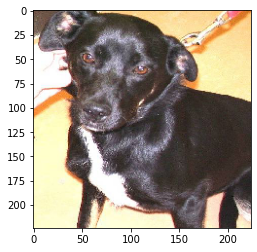

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
img = load_img(df["path"][0], target_size=(224, 224))
plt.imshow(img)

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
# 只要開始處理, 就不要df, 改用np.array
x = np.array(df["path"])
y = np.array(df["ans"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [7]:
from tensorflow.keras.applications.vgg16 import preprocess_input
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), batch)
    x_idx, y_idx = x[idx], y[idx]
    x_ori, x_norm, y_ori = [], [], y_idx
    for p in x_idx:
        img = np.array(load_img(p, target_size=(224, 224)))
        img_pre = preprocess_input(img)
        x_ori.append(img)
        x_norm.append(img_pre)
    return np.array(x_ori), np.array(x_norm), np.array(y_ori)
# get_data(x_train, y_train, 1)

In [ ]:
# 不取新的變數名稱就使用_
for i in range(10):
  print("[Times]:",i)
  _, x_batch, y_batch = get_data(x_train, y_train)
  result = model.train_on_batch(x_batch, y_batch)
  print("[Train]:",result)
  _, x_batch, y_batch = get_data(x_test, y_test, 100)
  result = model.test_on_batch(x_batch, y_batch)
  print("[Train]:",result)

In [ ]:
model.predict(x_batch)

In [29]:
x_ori, x_batch, y_batch = get_data(x_test, y_test, 1000)
model.evaluate(x_batch, y_batch)

32/32 [==============================] - 4s 113ms/step - loss: 2.7024 - accuracy: 0.9650


[2.7023704051971436, 0.9649999737739563]

In [ ]:
# argmax: 找最大值的index, 通常都是找最後一個軸(-1)
pre = model.predict(x_batch).argmax(axis = -1)
pre

In [31]:
trans = ["dog","cat"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14, 14))
idx = np.nonzero(pre != y_batch)[0]
idx = idx[:200]
width = 10
height = len(idx) // width + 1
for i, d  in enumerate(idx):
    img, label, p = x_ori[d], y_batch[d], pre[d]
    t = "[L]:{}\n[P]:{}".format(trans[label], trans[p])
    plt.subplot(height, width, i+1)
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)